# Mini Project 3 - Group 12

In [1]:
#Importing Necessary Libraries
import os
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from collections import Counter
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Loading the dataset
def load_data(directory):
    data = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
                content = file.read()
                data.append(content)
    return data

directory = 'Articles' # Replace with the path to your text files
raw_data = load_data(directory)


# 1. Preprocessing and exploratory data analysis

# Preprocessing of data

**Corpus Building**

In [3]:
#Pre-processing the data
def preprocess_data(raw_data):
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    preprocessed_data = []
    for document in raw_data:
        tokenized_words = word_tokenize(document.lower())
        cleaned_words = [word for word in tokenized_words if word.isalnum() and word not in stop_words]
        lemmatized_words = [lemmatizer.lemmatize(word) for word in cleaned_words]
        preprocessed_data.append(lemmatized_words)
    return preprocessed_data

preprocessed_data = preprocess_data(raw_data)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kaush\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kaush\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
preprocessed_data = ' '.join([' '.join(doc) for doc in preprocessed_data])

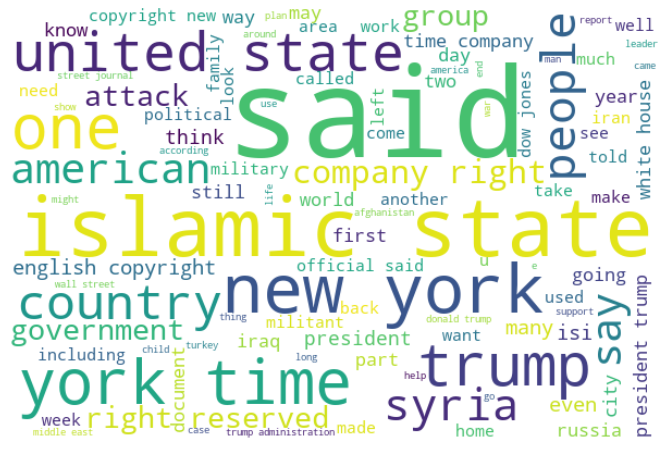

In [5]:
# Word Cloud Representation of Most commonly used Words
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_cloud(text, max_words=100):
    wordcloud = WordCloud(width=600, height=400, background_color='white', max_words=max_words).generate(text)

    plt.figure(figsize=(16, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

generate_word_cloud(preprocessed_data)


**Data Pre-processing**

In [6]:
import re

def extract_metadata(text):
    metadata = {}
    # Extract metadata here (e.g., title, author, date, etc.)
    # Example: metadata['title'] = re.search('TITLE_PATTERN', text).group(1)
    
    # Remove metadata from the text
    cleaned_text = re.sub('METADATA_PATTERN', '', text)
    return metadata, cleaned_text

def preprocess_data(raw_data):
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    preprocessed_data = []
    metadata_list = []

    for document in raw_data:
        metadata, cleaned_text = extract_metadata(document)
        metadata_list.append(metadata)

        tokenized_words = word_tokenize(cleaned_text.lower())
        cleaned_words = [re.sub(r'[^\w\s]', '', word) for word in tokenized_words if word.isalnum() and word not in stop_words]
        lemmatized_words = [lemmatizer.lemmatize(word) for word in cleaned_words]
        preprocessed_data.append(lemmatized_words)
    
    return metadata_list, preprocessed_data

metadata_list, preprocessed_data = preprocess_data(raw_data)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kaush\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kaush\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
dictionary = Dictionary(preprocessed_data)
corpus = [dictionary.doc2bow(doc) for doc in preprocessed_data]

**Feature Extraction**

In [8]:
def print_features(corpus, dictionary, document_index=0, num_features=10):
    bow_doc = corpus[document_index]
    sorted_bow = sorted(bow_doc, key=lambda x: x[1], reverse=True)

    print(f"Top {num_features} words in document {document_index}:\nWord\tFrequency")
    for word_id, freq in sorted_bow[:num_features]:
        print(f"{dictionary[word_id]}\t{freq}")

print_features(corpus, dictionary, document_index=0, num_features=10)

Top 10 words in document 0:
Word	Frequency
state	114
obama	94
said	89
afghanistan	86
attack	60
american	57
islamic	56
new	55
war	54
president	52


In [9]:
for i in range(1, 18):
    print_features(corpus, dictionary, document_index=i, num_features=10)

Top 10 words in document 1:
Word	Frequency
said	779
new	532
state	520
time	456
one	370
york	332
islamic	323
people	311
trump	311
would	284
Top 10 words in document 2:
Word	Frequency
said	823
state	652
time	543
new	503
islamic	422
york	391
iraq	298
one	267
group	255
american	250
Top 10 words in document 3:
Word	Frequency
said	658
new	551
time	524
state	505
york	383
islamic	314
year	301
trump	296
one	279
people	269
Top 10 words in document 4:
Word	Frequency
said	798
trump	754
state	712
new	514
time	474
one	381
would	353
united	351
people	343
president	343
Top 10 words in document 5:
Word	Frequency
state	972
trump	845
said	815
new	545
united	514
islamic	476
time	445
american	403
president	399
order	374
Top 10 words in document 6:
Word	Frequency
state	895
trump	837
said	644
new	504
united	492
time	467
country	394
american	365
people	359
president	320
Top 10 words in document 7:
Word	Frequency
trump	840
said	762
state	739
syria	590
time	471
new	448
president	400
american	399
islamic	352
mil

In [10]:
from collections import defaultdict
import numpy as np

def print_summary(corpus, dictionary, num_features=10):
    word_freqs = defaultdict(int)
    doc_lengths = []

    for doc in corpus:
        doc_length = 0
        for word_id, freq in doc:
            word_freqs[word_id] += freq
            doc_length += freq
        doc_lengths.append(doc_length)

    sorted_word_freqs = sorted(word_freqs.items(), key=lambda x: x[1], reverse=True)

    print(f"Top {num_features} words across all documents:\nWord\tFrequency")
    for word_id, freq in sorted_word_freqs[:num_features]:
        print(f"{dictionary[word_id]}\t{freq}")

    print(f"\nAverage word frequency: {np.mean(list(word_freqs.values())):.2f}")
    print(f"Average document length: {np.mean(doc_lengths):.2f}")

print_summary(corpus, dictionary, num_features=10)


Top 10 words across all documents:
Word	Frequency
said	11692
state	10457
trump	7730
islamic	6289
new	6230
time	5932
president	4372
one	4283
american	4088
syria	4083

Average word frequency: 28.09
Average document length: 58956.06


**Summarizing the features**

The results illustrates that there is a significant focus on politics and current events, as evidenced by the high frequency of words such as "state," "Trump," "president," and "Syria." The prominence of words like "Islamic" and "Iraq" suggests a focus on Middle Eastern politics and possibly terrorism. 

1) America has been involved in Syria since 2014, when it started leading an international coalition to fight against ISIS.

2) Turkey has been involved in Syria since 2011, when the Syrian civil war began. It has launched military operations in Syria against Kurdish militias that it considers to be terrorists.

3) America and Turkey have had a complicated relationship in Syria. Turkey has criticized America's support for Kurdish militias, which Turkey sees as a threat to its national security.

4) In 2017, Trump ordered a missile strike on a Syrian airbase.

5) In 2018, Trump announced that he was withdrawing American troops from Syria, saying that the mission to defeat ISIS had been accomplished.

6)  The Islamic State (ISIS) is a threat to every country, ISIS is a major terrorist group that has seized control of large swaths of territory in Syria and Iraq. The US and Turkey are both working to defeat ISIS

7) Turkey launched its military operation,  caused thousands of civilians to flee their homes and deaths 

8) The Syrian civil war has been going on for over a decade, and it has caused a humanitarian crisis of epic proportions.


Overall, the analysis indicates a heavy focus on politics and current events, particularly those related to the United States and the Middle East.

**Plots for exploration**

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_top_words(corpus, dictionary, num_features=10):
    word_freqs = defaultdict(int)

    for doc in corpus:
        for word_id, freq in doc:
            word_freqs[word_id] += freq

    sorted_word_freqs = sorted(word_freqs.items(), key=lambda x: x[1], reverse=True)
    top_words = [(dictionary[word_id], freq) for word_id, freq in sorted_word_freqs[:num_features]]

    return top_words

In [12]:
def get_doc_lengths(corpus):
    doc_lengths = []

    for doc in corpus:
        doc_length = 0
        for _, freq in doc:
            doc_length += freq
        doc_lengths.append(doc_length)

    return doc_lengths

OptionError: "No such keys(s): 'mode.use_inf_as_null'"

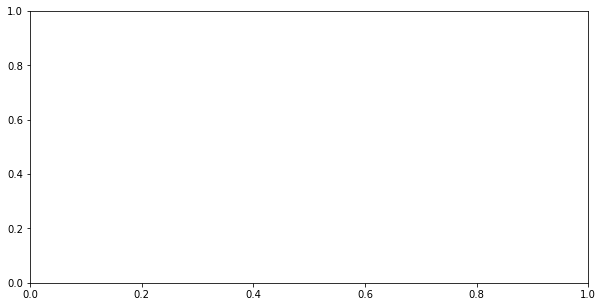

In [20]:
def plot_doc_lengths(corpus):
    doc_lengths = get_doc_lengths(corpus)

    plt.figure(figsize=(10, 5))
    sns.histplot(doc_lengths, kde=False, bins=30)
    plt.xlabel("Document Length")
    plt.ylabel("Number of Documents")
    plt.title("Histogram of Document Lengths")
    plt.show()
plot_doc_lengths(corpus)


In [21]:
import re
from nltk.tokenize import RegexpTokenizer

def extract_metadata(text):
    metadata = {}
    # Extract metadata here (e.g., title, author, date, etc.)
    # Example: metadata['title'] = re.search('TITLE_PATTERN', text).group(1)
    
    # Remove metadata from the text
    cleaned_text = re.sub('METADATA_PATTERN', '', text)
    return metadata, cleaned_text

def preprocess_data(raw_data):
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tokenizer = RegexpTokenizer(r'\w+|\$[\d\.]+|\S+')  # Tokenizes words and punctuation marks

    preprocessed_data = []
    metadata_list = []

    for document in raw_data:
        metadata, cleaned_text = extract_metadata(document)
        metadata_list.append(metadata)

        tokenized_words = tokenizer.tokenize(cleaned_text.lower())
        cleaned_words = [word for word in tokenized_words if word.isalnum() and word not in stop_words]
        lemmatized_words = [lemmatizer.lemmatize(word) for word in cleaned_words]
        preprocessed_data.append(lemmatized_words)
    
    return metadata_list, preprocessed_data

metadata_list, preprocessed_data = preprocess_data(raw_data)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kaush\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kaush\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2. Topic modeling

**Building LDA Model**

In [23]:
from gensim.models import LdaModel

def train_lda(corpus, dictionary, num_topics=5, passes=10, random_state=42):
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes, random_state=random_state)
    return lda_model

In [24]:
num_topics = 10
lda_model = train_lda(corpus, dictionary, num_topics=num_topics)

In [25]:
def print_topics(lda_model, num_words=10):
    topics = lda_model.print_topics(num_words=num_words)
    for topic_no, topic_words in topics:
        print(f"Topic {topic_no}: {topic_words}")

print_topics(lda_model, num_words=10)

Topic 0: 0.014*"manchester" + 0.013*"abedi" + 0.005*"aleppo" + 0.004*"township" + 0.004*"arena" + 0.004*"grande" + 0.004*"said" + 0.004*"clarke" + 0.003*"state" + 0.003*"trump"
Topic 1: 0.002*"said" + 0.001*"state" + 0.001*"islamic" + 0.001*"time" + 0.001*"trump" + 0.001*"president" + 0.001*"people" + 0.001*"new" + 0.001*"american" + 0.001*"right"
Topic 2: 0.010*"said" + 0.008*"state" + 0.008*"new" + 0.007*"time" + 0.005*"york" + 0.004*"islamic" + 0.004*"trump" + 0.004*"would" + 0.004*"one" + 0.004*"isi"
Topic 3: 0.012*"said" + 0.010*"state" + 0.007*"islamic" + 0.007*"trump" + 0.005*"time" + 0.005*"new" + 0.004*"syria" + 0.004*"president" + 0.004*"attack" + 0.004*"one"
Topic 4: 0.003*"said" + 0.003*"state" + 0.002*"islamic" + 0.002*"trump" + 0.002*"president" + 0.001*"attack" + 0.001*"force" + 0.001*"syria" + 0.001*"one" + 0.001*"government"
Topic 5: 0.012*"state" + 0.011*"trump" + 0.010*"said" + 0.007*"new" + 0.007*"united" + 0.006*"time" + 0.005*"islamic" + 0.005*"american" + 0.005*"

In [26]:
def save_topics_to_file(lda_model, filename, num_words=10):
    topics = lda_model.print_topics(num_words=num_words)
    with open(filename, 'w') as file:
        for topic_no, topic_words in topics:
            file.write(f"Topic {topic_no}: {topic_words}\n")

**Re-run the topic modeling multiple times with different parameters and store summaries into output files**

In [27]:
num_topics_values = [3, 5, 7]
num_passes_values = [5, 10, 20]

for num_topics in num_topics_values:
    for passes in num_passes_values:
        print(f"Training LDA model with {num_topics} topics and {passes} passes.")
        lda_model = train_lda(corpus, dictionary, num_topics=num_topics, passes=passes)
        
        print(f"Topics for LDA model with {num_topics} topics and {passes} passes:")
        print_topics(lda_model, num_words=10)
        
        output_filename = f"lda_topics_{num_topics}_topics_{passes}_passes.txt"
        save_topics_to_file(lda_model, output_filename, num_words=10)
        print(f"Saved topics to {output_filename}\n")

Training LDA model with 3 topics and 5 passes.
Topics for LDA model with 3 topics and 5 passes:
Topic 0: 0.010*"said" + 0.009*"state" + 0.008*"trump" + 0.006*"new" + 0.005*"time" + 0.005*"islamic" + 0.004*"president" + 0.004*"york" + 0.004*"one" + 0.004*"would"
Topic 1: 0.010*"said" + 0.010*"state" + 0.008*"islamic" + 0.007*"time" + 0.005*"new" + 0.005*"american" + 0.004*"trump" + 0.004*"york" + 0.004*"people" + 0.004*"president"
Topic 2: 0.012*"said" + 0.010*"state" + 0.008*"trump" + 0.006*"new" + 0.006*"islamic" + 0.005*"time" + 0.004*"syria" + 0.004*"one" + 0.004*"president" + 0.004*"would"
Saved topics to lda_topics_3_topics_5_passes.txt

Training LDA model with 3 topics and 10 passes.
Topics for LDA model with 3 topics and 10 passes:
Topic 0: 0.010*"said" + 0.009*"state" + 0.008*"trump" + 0.006*"new" + 0.005*"islamic" + 0.005*"time" + 0.004*"president" + 0.004*"one" + 0.004*"would" + 0.004*"people"
Topic 1: 0.011*"said" + 0.010*"state" + 0.007*"time" + 0.007*"islamic" + 0.006*"new

In [28]:
import pyLDAvis.gensim_models

def visualize_lda_model(lda_model, corpus, dictionary):
    vis_data = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
    pyLDAvis.display(vis_data)

visualize_lda_model(lda_model, corpus, dictionary)

In [29]:
def get_topic_top_words(lda_model, topic_id, num_words=10):
    words_and_probs = lda_model.show_topic(topic_id, topn=num_words)
    return words_and_probs

topic_top_words = {}
for topic_id in range(num_topics):
    topic_top_words[topic_id] = get_topic_top_words(lda_model, topic_id)

for topic_id, top_words in topic_top_words.items():
    print(f"Topic {topic_id}:")
    for word, probability in top_words:
        print(f"    {word}: {probability:.4f}")

Topic 0:
    said: 0.0102
    state: 0.0085
    time: 0.0071
    new: 0.0066
    trump: 0.0060
    facebook: 0.0050
    american: 0.0048
    york: 0.0044
    islamic: 0.0044
    president: 0.0040
Topic 1:
    said: 0.0001
    state: 0.0001
    islamic: 0.0001
    time: 0.0001
    trump: 0.0001
    president: 0.0001
    new: 0.0001
    people: 0.0001
    american: 0.0001
    would: 0.0001
Topic 2:
    said: 0.0098
    new: 0.0078
    time: 0.0075
    state: 0.0074
    york: 0.0052
    islamic: 0.0046
    one: 0.0040
    year: 0.0039
    trump: 0.0039
    people: 0.0036
Topic 3:
    said: 0.0116
    state: 0.0103
    trump: 0.0073
    islamic: 0.0069
    syria: 0.0049
    new: 0.0044
    time: 0.0044
    president: 0.0043
    force: 0.0042
    military: 0.0040
Topic 4:
    said: 0.0109
    trump: 0.0080
    state: 0.0075
    time: 0.0059
    new: 0.0056
    attack: 0.0054
    islamic: 0.0050
    manchester: 0.0047
    president: 0.0047
    people: 0.0042
Topic 5:
    state: 0.0107
    sa

**Result Discusssion**

Topic 0 seems to be related to a specific event that happened in Manchester and mentions the name "Abedi" along with other related words like "arena" and "Grande". This could be referring to the 2017 Manchester Arena bombing.

Topic 1 appears to be a general topic that mentions words like "president," "American," and "right." It is unclear what specific event or topic this could be referring to.

Topic 2 seems to be focused on the state of New York and mentions the word "ISI," which is likely a reference to ISIS. It is possible that this topic is discussing the presence or activity of ISIS in New York.

Topic 3 also mentions ISIS and appears to be focused on their activity in Syria. The topic also includes words like "attack" and "president," which could be referring to a specific incident or action taken by the president in response to ISIS activity.

Topic 4 appears to be a continuation of the previous topic, discussing ISIS and their presence in Syria.

Topic 5 is focused on the United States and mentions the current president, Donald Trump, along with words like "American" and "country." This could be referring to various political or social issues within the United States.

Topic 6 mentions hacking and a team, and it is possible that this topic is related to cyber attacks or cybersecurity in general.

Overall, the topics appear to be a mix of specific events and general news topics, with a focus on ISIS and the United States. 

**Outputs and visualizations**

In [30]:
def get_document_topic_proportions(lda_model, corpus):
    topic_proportions = []
    for doc_topics in lda_model.get_document_topics(corpus):
        proportions = {topic_id: 0 for topic_id in range(lda_model.num_topics)}
        for topic_id, proportion in doc_topics:
            proportions[topic_id] = proportion
        topic_proportions.append(proportions)
    return topic_proportions

document_topic_proportions = get_document_topic_proportions(lda_model, corpus)

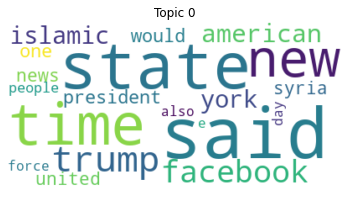

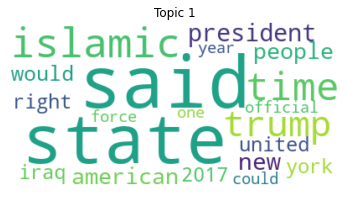

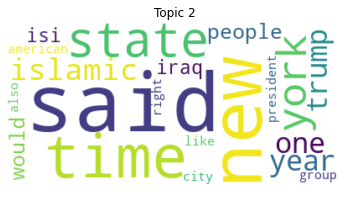

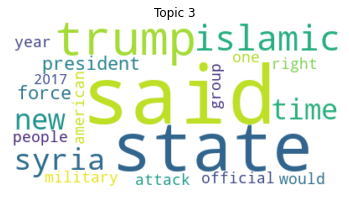

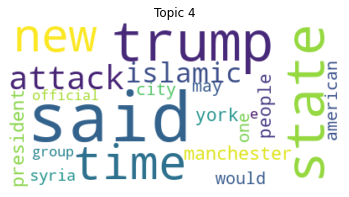

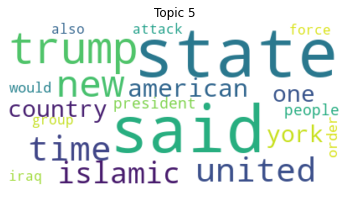

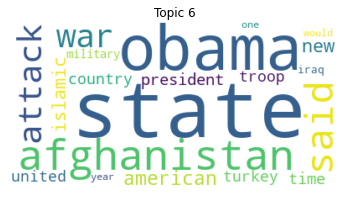

In [31]:
# Generate wordclouds for each topic
for topic_num in range(lda_model.num_topics):
    words = dict(lda_model.show_topic(topic_num, topn=20))
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Topic {}".format(topic_num))
    plt.show()